In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path

import sys
sys.path.insert(0, '../completenessContours')
import compute_num_completeness_w_ve_insol as kp

sys.path.insert(0, '..')
import occRateModels as rm
import occRateUtils as ut

import rateModels3D as rm3D

In [2]:
figDir = "summaryFigures"

cs = ut.compSpace(periodName = "Insolation", 
               periodUnits = "Earth Flux",
               periodRange = (0.2, 2.0), 
               nPeriod = 61, 
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.75, 2.5), 
               nRp = 61)

model = rm.dualPowerLaw()


In [3]:
inputgrid = "../completenessContours/out_sc0_hab2_insol_teff_extrap_const.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtotConst = cumulative_array[2]
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
min_comp_flux = prihdr["MINFLX"]
max_comp_flux = prihdr["MAXFLX"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)


In [4]:
inputgrid = "../completenessContours/out_sc0_hab2_insol_teff.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtotZero = cumulative_array[2]
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
min_comp_flux = prihdr["MINFLX"]
max_comp_flux = prihdr["MAXFLX"]


Plot the difference between the constrant-extrapolated and zero-extrapolated completeness as an average (rather than sum).

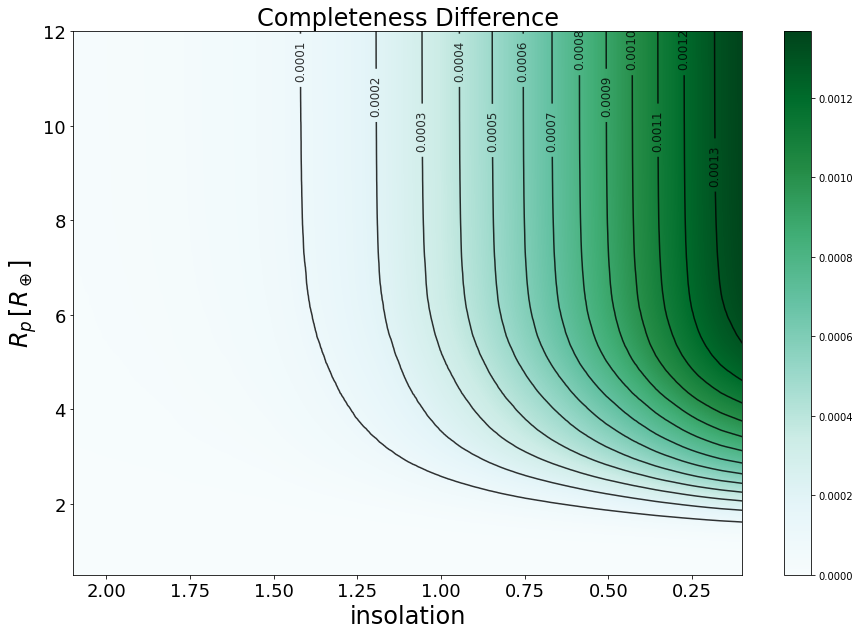

In [5]:
contourLevels = np.arange(1e-4, 2e-3, 1e-4)
# contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])

innerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 0.75)
outerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 1.77)

probDiff = (probtotConst - probtotZero)/ kiclist.size;
fig, ax = plt.subplots(figsize=(15,10));

insol_want = np.linspace(max_comp_flux, min_comp_flux, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)

plt.pcolor(insol_want, rp_want, probDiff, cmap="BuGn")
plt.colorbar()
c = plt.contour(insol_want, rp_want, probDiff, contourLevels, 
               colors="k", alpha=0.8)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
# plt.ylim(0.5, 2.5)
xlim = plt.xlim();
plt.xlim(xlim[1], xlim[0]);
# plt.xlim(50, 400)
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("insolation", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
plt.title("Completeness Difference", fontsize = 24);


Plot the relative difference ((Constant-extrapolated - Zero-extrapolated)/Constant-extrapolated) between the constrant-extrapolated and zero-extrapolated completeness.

In [6]:
import matplotlib

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

light_BuGn = cmap_map(lambda x: x/2 + 0.5, plt.cm.get_cmap('GnBu'))


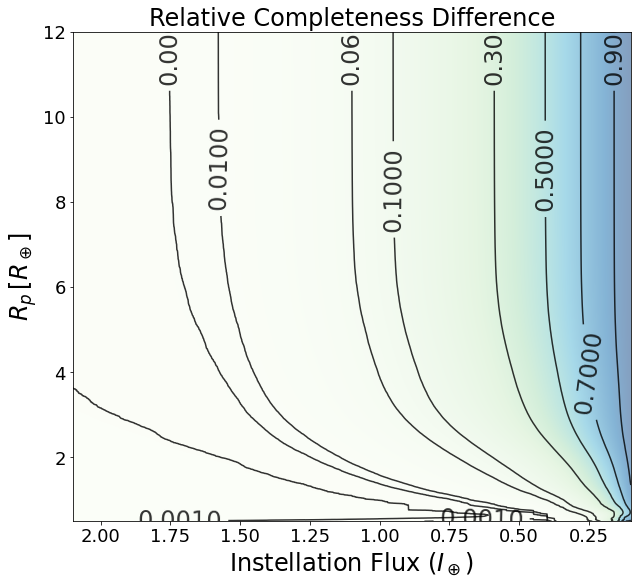

In [7]:
contourLevels = np.arange(0.1, 1, 0.2)
contourLevels = np.insert(contourLevels, 0, np.arange(0.01, 0.1, 0.05))
contourLevels = np.insert(contourLevels, 0, np.arange(0.001, 0.01, 0.005))
fig, ax = plt.subplots(figsize=(10,9));
probDiff = (probtotConst - probtotZero)/(probtotConst + 1e-15)
plt.pcolor(insol_want, rp_want, probDiff, cmap=light_BuGn)
# cbh = plt.colorbar()
# cbh.ax.tick_params(labelsize=18)
c = plt.contour(insol_want, rp_want, probDiff, contourLevels, 
               colors="k", alpha=0.8)
plt.clabel(c, fontsize=24, inline=1, fmt="%.4f")


#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
# plt.ylim(0.5, 2.5)
xlim = plt.xlim();
plt.xlim(xlim[1], xlim[0]);
# plt.xlim(50, 400)
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel('Instellation Flux ($I_\oplus$)', fontsize = 24);
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
plt.savefig(figDir + "/completenessDifference.png",bbox_inches='tight')
plt.title("Relative Completeness Difference", fontsize = 24);


In [8]:
from scipy import interpolate

cs = rm3D.compSpace(periodName = "Insolation", 
               periodUnits = "Earth Flux",
               periodRange = (0.2, 2.2), 
               nPeriod = 61, 
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.5, 2.5), 
               nRp = 61,
               tempName = "$T_\mathrm{eff}$", 
               tempUnits = "$R_\oplus$",
               tempRange = (3900, 7300), 
               nTemp = 10)

hdulist = fits.open("../completenessContours/out_sc0_FGK_insol_teff.fits.gz")
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = cumulative_array[2]
probTeffZero = cumulative_array[3:,:,:]
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
min_comp_flux = prihdr["MINFLX"]
max_comp_flux = prihdr["MAXFLX"]

nTeff = prihdr["NTEFF"]
nstars = np.zeros(nTeff)
for i in range(nTeff):
    nstars[i] = prihdr["NSTEFF" + str(i)]
print(nstars)
meanTeff = np.zeros(nTeff)
for i in range(nTeff):
    meanTeff[i] = prihdr["MEANT" + str(i)]
print(meanTeff)

# period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
period_want = np.linspace(max_comp_flux, min_comp_flux, n_comp_period) 
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = interpolate.interp2d(period_want, rp_want, probtot);
summedCompleteness = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))

summedCompletenessTeffZero = np.zeros((cs.nPeriod, cs.nRp, nTeff))
for i in range(nTeff):
    numCompVeInterp = interpolate.interp2d(period_want, rp_want, probTeffZero[i,:,:])
    summedCompletenessTeffZero[:,:,i] = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))

hdulist = fits.open("../completenessContours/out_sc0_FGK_insol_teff_extrap_const.fits.gz")
cumulative_array = hdulist[0].data
probTeffConst = cumulative_array[3:,:,:]
summedCompletenessTeffConst = np.zeros((cs.nPeriod, cs.nRp, nTeff))
for i in range(nTeff):
    numCompVeInterp = interpolate.interp2d(period_want, rp_want, probTeffConst[i,:,:])
    summedCompletenessTeffConst[:,:,i] = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))



[ 1600.  2637.  4746.  8876. 15495. 20473. 14374.  8913.  3095.   720.]
[4095.21516051 4422.8398577  4763.46230516 5111.24240992 5443.05356942
 5770.0334996  6094.64024283 6423.18539926 6757.67956261 7074.58855108]


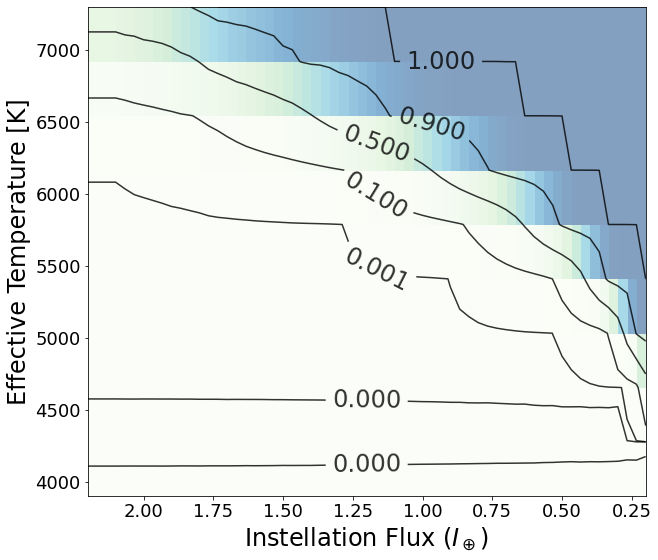

In [9]:
contourLevels = [0,  1e-3, 1e-1, 0.5, 0.9, 1-0.000001]

fig, ax = plt.subplots(figsize=(10,9));

sc = 0.5 * (summedCompletenessTeffZero[:, 1:, :] + summedCompletenessTeffZero[:, :-1, :])
scsZero = np.sum(sc * np.diff(cs.rp1D)[None,:, None], axis=1)
scsZero = scsZero*(len(kiclist)/nstars)[None,:] / kiclist.size

sc = 0.5 * (summedCompletenessTeffConst[:, 1:, :] + summedCompletenessTeffConst[:, :-1, :])
scsConst = np.sum(sc * np.diff(cs.rp1D)[None,:, None], axis=1)
scsConst = scsConst*(len(kiclist)/nstars)[None,:] / kiclist.size

scsDiff = (scsConst - scsZero)/scsConst

pc = plt.pcolor(cs.period2DTemp, cs.temp2D, scsDiff, cmap=light_BuGn)
# cbh = plt.colorbar()
# cbh.ax.tick_params(labelsize=18)
c = plt.contour(cs.period2DTemp, cs.temp2D, scsDiff, contourLevels,
               colors="k", alpha=0.8)
xl = plt.xlim()
plt.xlim(xl[1], xl[0])
plt.clabel(c, fontsize=24, inline=1, fmt="%.3f", use_clabeltext=True)
# cbh = plt.colorbar(pc);
# cbh.ax.set_ylabel("Average Completeness", fontsize = 24);
# cbh.ax.tick_params(labelsize=24)
plt.tick_params(labelsize = 18)
plt.xlabel('Instellation Flux ($I_\oplus$)', fontsize = 24);
# plt.ylabel("Planet Radius [$R_\oplus$]", fontsize = 24);
plt.ylabel("Effective Temperature [K]", fontsize = 24);
plt.savefig(figDir + "/completenessFluxTDiff.png",bbox_inches='tight')


In [10]:
scsConst

array([[2.82663090e-03, 1.55684563e-03, 4.73372430e-04, 3.18907429e-04,
        2.85621560e-04, 2.54505886e-04, 2.47262539e-04, 1.61444613e-04,
        6.37037593e-05, 4.58614280e-05],
       [3.28289264e-03, 2.01268489e-03, 7.39886346e-04, 3.23378778e-04,
        2.85629229e-04, 2.54505886e-04, 2.47262539e-04, 1.61444613e-04,
        6.37037593e-05, 4.58614280e-05],
       [3.71202769e-03, 2.36481027e-03, 1.11454683e-03, 3.52277186e-04,
        2.85704926e-04, 2.54505886e-04, 2.47262539e-04, 1.61444613e-04,
        6.37037593e-05, 4.58614280e-05],
       [4.12809892e-03, 2.68857325e-03, 1.48572012e-03, 4.29836455e-04,
        2.86150314e-04, 2.54505886e-04, 2.47262539e-04, 1.61444613e-04,
        6.37037593e-05, 4.58614280e-05],
       [4.54665728e-03, 2.98331724e-03, 1.79489663e-03, 5.79288696e-04,
        2.88990865e-04, 2.54505886e-04, 2.47262539e-04, 1.61444613e-04,
        6.37037593e-05, 4.58614280e-05],
       [4.94127964e-03, 3.26951547e-03, 2.04391926e-03, 7.81014676e-04,
   

/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys
/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


<a list of 0 text.Text objects>

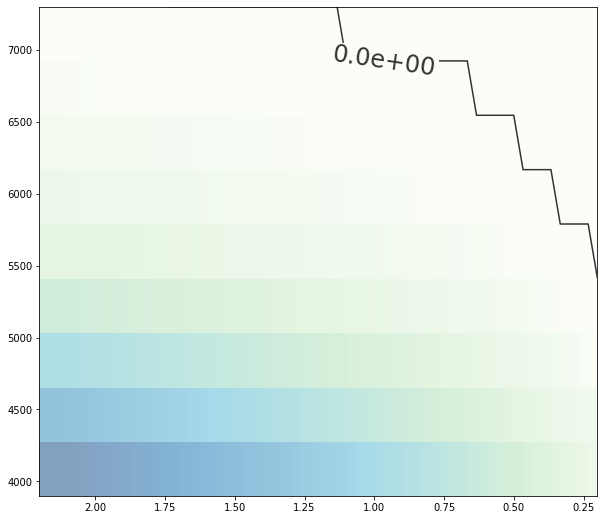

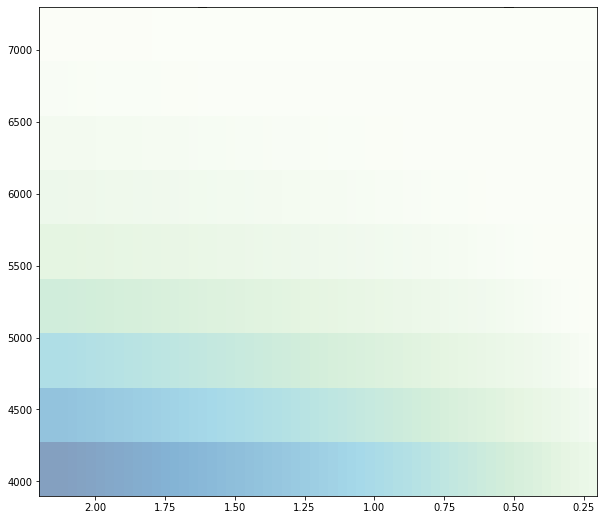

In [11]:
contourLevels = [0,  1e-6, 1e-5, 1e-4, 1e-3]
fig, ax = plt.subplots(figsize=(10,9));
pc = plt.pcolor(cs.period2DTemp, cs.temp2D, scsZero / kiclist.size, cmap=light_BuGn)
# cbh = plt.colorbar()
# cbh.ax.tick_params(labelsize=18)
c = plt.contour(cs.period2DTemp, cs.temp2D, scsZero / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
xl = plt.xlim()
plt.xlim(xl[1], xl[0])
plt.clabel(c, fontsize=24, inline=1, fmt="%.1e", use_clabeltext=True)

fig, ax = plt.subplots(figsize=(10,9));
pc = plt.pcolor(cs.period2DTemp, cs.temp2D, scsConst / kiclist.size, cmap=light_BuGn)
# cbh = plt.colorbar()
# cbh.ax.tick_params(labelsize=18)
c = plt.contour(cs.period2DTemp, cs.temp2D, scsConst / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
xl = plt.xlim()
plt.xlim(xl[1], xl[0])
plt.clabel(c, fontsize=24, inline=1, fmt="%.1e", use_clabeltext=True)


In [12]:
samples_constExtrap = np.load("occ_dualPowerLaw_extrap_const_out/occurenceRatePosteriors.npy")
samples_zeroExtrap = np.load("occ_dualPowerLaw_extrap_zero_out/occurenceRatePosteriors.npy")


FileNotFoundError: [Errno 2] No such file or directory: 'occ_dualPowerLaw_extrap_const_out/occurenceRatePosteriors.npy'

In [ ]:
exopagHz_constExtrap = model.integrate([outerHZ,innerHZ], [0.5,1.5], samples_constExtrap[:-1:10,:], cs)
exopagHz_zeroExtrap = model.integrate([outerHZ,innerHZ], [0.5,1.5], samples_zeroExtrap[:-1:10,:], cs)


In [ ]:
KHZDist_constExtrap = model.integrate([0.25,1.8], [0.5,1.5], samples_constExtrap[:-1:10,:], cs)
KHZDist_zeroExtrap = model.integrate([0.25,1.8], [0.5,1.5], samples_zeroExtrap[:-1:10,:], cs)


In [ ]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
plt.hist(exopagHz_constExtrap, 100, histtype="stepfilled", density=True, alpha = 0.5);
plt.hist(exopagHz_zeroExtrap, 100, histtype="stepfilled", density=True, alpha = 0.5);
# plt.hist(KHZDist_nr, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.text(0.6, 2.3, r"ExoPAG $\eta_{\oplus}$ with constant extrapolation = $" + ut.printMedianAndErrorbars(exopagHz_constExtrap) + "$", fontSize = 24)
plt.text(0.6, 2.1, r"ExoPAG $\eta_{\oplus}$ with zero extrapolation = $" + ut.printMedianAndErrorbars(exopagHz_zeroExtrap) + "$", fontSize = 24)
plt.xlabel(r"$\eta_{\oplus}$", fontSize = 36);
plt.savefig("compareExopagEtaEarth.pdf",bbox_inches='tight')
# plt.title("Kopparapu Habitable Zone Distribution, 0.5-1.5 $R_\oplus$", fontsize=18);


In [ ]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
plt.hist(KHZDist_constExtrap, 100, histtype="stepfilled", density=True, alpha = 0.5);
plt.hist(KHZDist_zeroExtrap, 100, histtype="stepfilled", density=True, alpha = 0.5);
# plt.hist(KHZDist_nr, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.text(0.6, 1.8, r"Kopparapu* $\eta_{\oplus}$ with constant extrapolation = $" + ut.printMedianAndErrorbars(KHZDist_constExtrap) + "$", fontSize = 24)
plt.text(0.6, 1.65, r"Kopparapu* $\eta_{\oplus}$ with zero extrapolation = $" + ut.printMedianAndErrorbars(KHZDist_zeroExtrap) + "$", fontSize = 24)
plt.text(1, 1.53, "* a flux-radius box enclosing the Kopparapu optimistic habitable zone", fontSize = 18)
plt.xlabel(r"$\eta_{\oplus}$", fontSize = 36);
plt.savefig("compareKoppEtaEarth.pdf",bbox_inches='tight')
# plt.title("Kopparapu Habitable Zone Distribution, 0.5-1.5 $R_\oplus$", fontsize=18);


In [ ]:
def getHzFlux(teff):
    Ts = teff - 5780
    # erratum Kopperapu 2013
    KoppHzOptIn = 1.7763 + 1.4335e-4*Ts + 3.3954e-9*Ts**2 + -7.6364e-12*Ts**3 + -1.1950e-15*Ts**4
    KoppHzInRunGreen = 1.0385 + 1.2456e-4*Ts + 1.4612e-8*Ts**2 + -7.6345e-12*Ts**3 + -1.711e-15*Ts**4
    KoppHzPessIn = 1.0146 + 8.1884e-5*Ts + 1.9394e-9*Ts**2 + -4.3618e-12*Ts**3 + -6.8260e-16*Ts**4
    KoppHzOut = 0.3507 + 5.9578e-5*Ts + 1.6707e-9*Ts**2 + -3.0058e-12*Ts**3 + -5.1925e-16*Ts**4
    
#     return KoppHzOptIn, KoppHzOut, KoppHzPessIn, KoppHzInRunGreen
    return KoppHzOptIn, KoppHzOut

In [ ]:
def starHzOccRate(stars, rpRange, samples, model, cs, nSamples=None):
    KoppHzOptIn, KoppHzOut = getHzFlux(stars.teff)
    f = FloatProgress(min=0, max=len(stars))
    display(f)
    if samples.ndim == 1:
        hzOptOccRate = np.zeros(len(stars))
        for s in range(len(stars)):        
            hzOptOccRate[s] = model.integrate(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], samples, cs)
#             hzOptOccRate[s] = ut.integrateRateModel(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], samples, model, cs)
            f.value += 1
    else:
        hzOptOccRate = np.zeros((len(stars), nSamples))
        for s in range(len(stars)):        
            if nSamples != None:
                sampleIndex = np.floor(samples.shape[0]*np.random.rand(nSamples)).astype(int)
                useSamples = samples[sampleIndex,:]
            else:
                useSamples = samples
            hzOptOccRate[s,:] = model.integrate(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], useSamples, cs)
#             hzOptOccRate[s,:] = ut.integrateRateModel(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], useSamples, model, cs)
            f.value += 1
        
    return hzOptOccRate

In [ ]:
def fluxHzOccRate(teffRange, rpRange, samples, model, cs, nSamples=None):
    KoppHzOptIn, KoppHzOut = getHzFlux(np.linspace(teffRange[0], teffRange[1], 1000))
    f = FloatProgress(min=0, max=len(KoppHzOptIn))
    display(f)
    if samples.ndim == 1:
        hzOptOccRate = np.zeros(len(KoppHzOptIn))
        for s in range(len(KoppHzOptIn)):        
            hzOptOccRate[s] = model.integrate(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], samples, cs)
#             hzOptOccRate[s] = ut.integrateRateModel(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], samples, model, cs)
            f.value += 1
    else:
        hzOptOccRate = np.zeros((len(KoppHzOptIn), nSamples))
        for s in range(len(KoppHzOptIn)):        
            if nSamples != None:
                sampleIndex = np.floor(samples.shape[0]*np.random.rand(nSamples)).astype(int)
                useSamples = samples[sampleIndex,:]
            else:
                useSamples = samples
            hzOptOccRate[s,:] = model.integrate(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], useSamples, cs)
#             hzOptOccRate[s,:] = ut.integrateRateModel(rpRange, [KoppHzOut[s], KoppHzOptIn[s]], useSamples, model, cs)
            f.value += 1
        
    return hzOptOccRate

In [ ]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_berger2019_clean_GK.txt"
stellarTargets = pd.read_csv(stellarCatalog)


In [ ]:
stellarHzDist_constExtrap = starHzOccRate(stellarTargets, [0.5,1.5], samples_constExtrap, model, cs, nSamples = 100)
stellarHzDist_zeroExtrap = starHzOccRate(stellarTargets, [0.5,1.5], samples_zeroExtrap, model, cs, nSamples = 100)


In [ ]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
dist = stellarHzDist_constExtrap.flatten()
plt.hist(dist[dist<5], 1000, histtype="stepfilled", density=True, alpha = 0.5);
dist = stellarHzDist_zeroExtrap.flatten()
plt.hist(dist[dist<5], 1000, histtype="stepfilled", density=True, alpha = 0.5);
# plt.hist(KHZDist_nr, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.text(1.0, 1.6, r"constant extrapolation $\eta_{\oplus} = " 
         + ut.printMedianAndErrorbars(stellarHzDist_constExtrap.flatten()) + "$", fontSize = 32)
plt.text(1.0, 1.2, r"zero extrapolation $\eta_{\oplus} = " 
         + ut.printMedianAndErrorbars(stellarHzDist_zeroExtrap.flatten()) + "$", fontSize = 32)
plt.xlabel("Kopparapu Optimistic Habitable Zone", fontSize = 36);
plt.xlim(0,5)
# plt.savefig(outDir + "/stellarKHZDist.pdf",bbox_inches='tight')


In [ ]:
fluxHzDist_constExtrap = fluxHzOccRate([3900, 6000], [0.5,1.5], samples_constExtrap, model, cs, nSamples = 1000)
fluxHzDist_zeroExtrap = fluxHzOccRate([3900, 6000], [0.5,1.5], samples_zeroExtrap, model, cs, nSamples = 1000)


In [ ]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
dist = fluxHzDist_constExtrap.flatten()
plt.hist(dist[dist<5], 1000, histtype="stepfilled", density=True, alpha = 0.5);
dist = fluxHzDist_zeroExtrap.flatten()
plt.hist(dist[dist<5], 1000, histtype="stepfilled", density=True, alpha = 0.5);
# plt.hist(KHZDist_nr, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.text(1.0, 1.6, r"constant extrapolation $\eta_{\oplus} = " 
         + ut.printMedianAndErrorbars(fluxHzDist_constExtrap.flatten()) + "$", fontSize = 32)
plt.text(1.0, 1.2, r"zero extrapolation $\eta_{\oplus} = " 
         + ut.printMedianAndErrorbars(fluxHzDist_zeroExtrap.flatten()) + "$", fontSize = 32)
plt.xlabel("Kopparapu Optimistic Habitable Zone", fontSize = 36);
plt.xlim(0,5)


In [ ]:
modelName = model.name

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
%%bash -s  "$modelName"
jupyter nbconvert --to html compareCompleteness.ipynb
mv compareCompleteness.html htmlArchive/compareCompleteness_$1.html